In [1]:
!pip install tensorflow==2.7.0 pandas matplotlib tensorflow-datasets ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 430.8/430.8 MB 3.8 MB/s eta 0:00:00
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     -------------------------------------- 463.1/463.1 KB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires flatbuffers>=23.5.26, but you have flatbuffers 2.0.7 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.7.0 which is incompatible.
tensorflow-intel 2.15.0 requires tensorflow-estimator<2.16,>=2.15.0, but you have tensorflow-estimator 2.7.0 which is incompatible.
You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
#imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
import cv2


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

if gpus:
    print('gpu found')
for gpu in gpus:
    print(gpu)

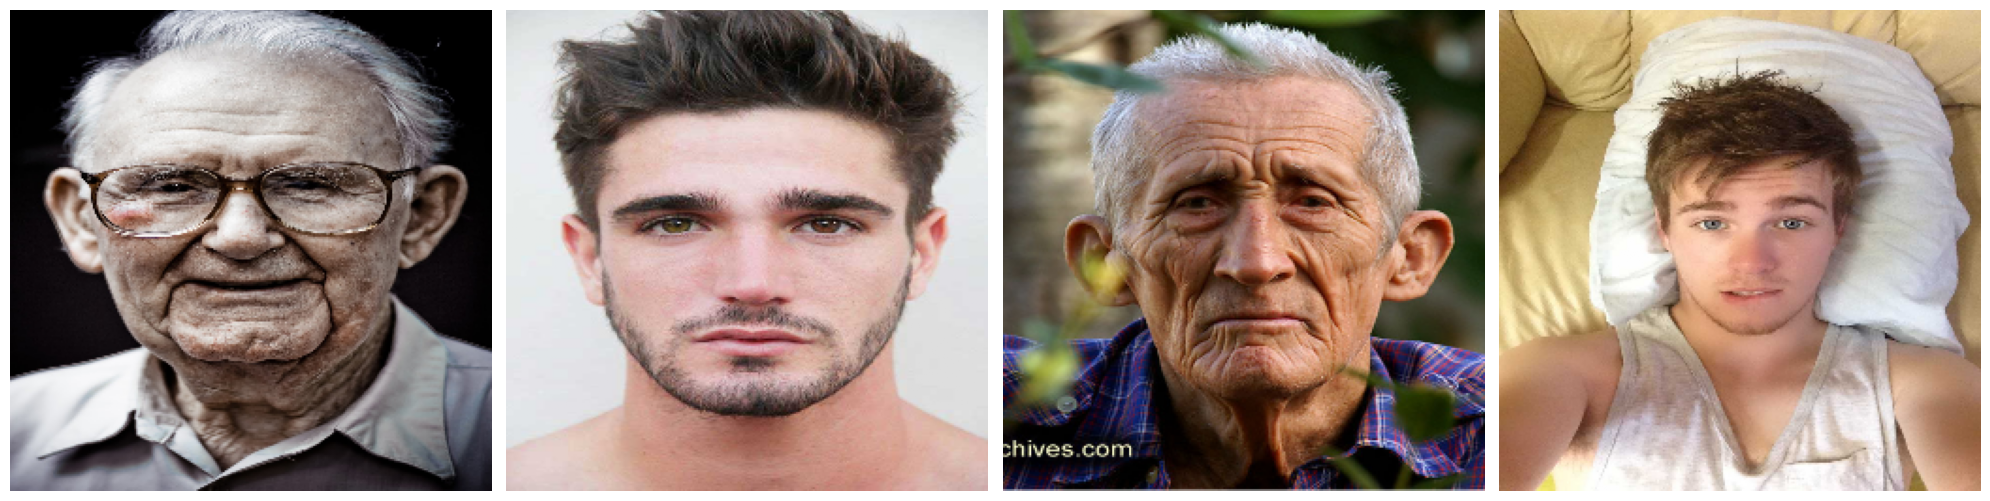

In [3]:
humans_folder = 'Humans'

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    file_path = file_path.numpy().decode('utf-8')  # Convert tensor to string
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"Failed to load image: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    return img


file_paths = [os.path.join(humans_folder, filename) for filename in os.listdir(humans_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))]

ds = tf.data.Dataset.from_tensor_slices(file_paths)
ds = ds.map(lambda x: tf.py_function(load_and_preprocess_image, [x], tf.float32))
ds = ds.map(lambda x: tf.reshape(x, [256, 256, 3]))

dataIterator = ds.as_numpy_iterator()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    try:
        sam = next(dataIterator)
        ax[i].imshow(sam)
        ax[i].axis('off')
    except StopIteration:
        print(f"Ran out of images after {i} iterations")
        break

plt.tight_layout()
plt.show()

In [4]:
ds = ds.cache()
ds = ds.shuffle(7500)
ds = ds.batch(32)
ds = ds.prefetch(64)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Input

In [7]:
def build_generator():
    model = Sequential([
        Input(shape=(256,)),
        
        # Dense layer
        Dense(8 * 8 * 256),
        LeakyReLU(0.2),
        Reshape((8, 8, 256)),
        
        # Upsampling blocks
        UpSampling2D(),
        Conv2D(512, 5, padding='same'),
        LeakyReLU(0.2),
        
        UpSampling2D(),
        Conv2D(256, 5, padding='same'),
        LeakyReLU(0.2),
        
        UpSampling2D(),
        Conv2D(256, 5, padding='same'),
        LeakyReLU(0.2),
        
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        
        UpSampling2D(),
        Conv2D(64, 5, padding='same'),
        LeakyReLU(0.2),
        
        # Final convolutional layers
        Conv2D(32, 3, padding='same'),
        LeakyReLU(0.2),
        
        # Output layer
        Conv2D(3, 3, padding='same', activation='tanh')
    ])
    
    return model

In [8]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             4210688   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 512)       3277312   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                        

(1, 256, 256, 3)


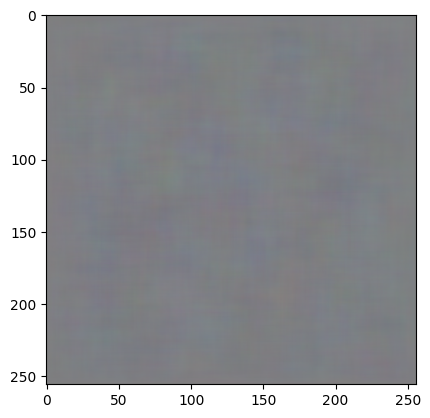

In [9]:
img = generator.predict(np.random.normal(0,1,(1,256)))

print(img.shape)

#the output of the generator is in the range of [-1, 1], so we need to rescale it to [0,1]
img = (img + 1)/ 2.0
plt.imshow(img[0])

#The shape (1, 256, 256, 3) denotes (batch size, width, height, channels)

In [10]:
def build_discriminator():
    model = Sequential([
        # First convolutional layer
        Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(256, 256, 3)),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),

        # Second convolutional layer
        Conv2D(128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),

        # Third convolutional layer
        Conv2D(256, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),

        # Fourth convolutional layer
        Conv2D(512, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),

        # Flatten the output
        Flatten(),

        # Dense layer
        Dense(1, activation='sigmoid')
    ])

    return model

In [11]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 256)      

In [12]:
#Checking for discriminator's compatibilty with generator.
result = discriminator.predict(img)
print(result)

[[0.49693915]]


In [14]:

from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.0001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [16]:
#Constructing the training loop
from keras.models import Model
class GANgen(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
        pass
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        pass

    def train_step(self, batch):
        real_images = batch
        batch_size = tf.shape(real_images)[0]
        
        # Generate fake images
        fake_images = self.generator(tf.random.normal((batch_size, 256)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        d_gradient = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((batch_size, 256)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}
        pass

    def test_step(self):
        pass

In [17]:
facegen = GANgen(generator, discriminator)
facegen.compile(g_opt, d_opt, g_loss, d_loss)


In [18]:
#Building a callback (Template code)
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=256):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # Generate random noise vectors
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        
        # Generate images
        generated_images = self.model.generator(random_latent_vectors)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2.0
        
        # Convert to numpy and scale to [0, 255]
        generated_images = (generated_images.numpy() * 255).astype('uint8')
        
        # Save images
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [19]:
!pip install gputil

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [20]:
import tensorflow as tf
import GPUtil
import psutil

# Force TensorFlow to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and will be used")
else:
    print("No GPU found. Using CPU.")

def print_gpu_utilization():
    GPUs = GPUtil.getGPUs()
    for i, gpu in enumerate(GPUs):
        print(f'GPU {i} - Memory: {gpu.memoryUtil*100:.2f}%, GPU Utilization: {gpu.load*100:.2f}%')

def print_memory_utilization():
    print(f"RAM Memory: {psutil.virtual_memory().percent:.2f}%")

# Your existing GAN model (facegen) and dataset (ds) should be defined before this point

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_idx, batch in enumerate(ds):
        # Ensure the operations run on GPU
        with tf.device('/GPU:0'):
            # Train step
            losses = facegen.train_step(batch)
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f"Batch {batch_idx}: D loss: {losses['d_loss']:.4f}, G loss: {losses['g_loss']:.4f}")
            print_gpu_utilization()
            print_memory_utilization()
    
    # End of epoch
    print(f"End of Epoch {epoch + 1}")
    print_gpu_utilization()
    print_memory_utilization()
    
    ModelMonitor().on_epoch_end(epoch)
    
    # Optionally save your model periodically
    if (epoch + 1) % 5 == 0:
        facegen.save_weights(f'facegen_epoch_{epoch+1}.h5')

print("Training completed")

No GPU found. Using CPU.
Epoch 1/20
